In [1]:
import json
import math
import os

import jaxlie
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
colors = 'Accent'
sns.set_palette(colors)
import warnings
warnings.filterwarnings('ignore')

# Coarse fine

In [3]:
def convergence_speed(data, threshold=0.1):
    t_errors = np.array(data['history']['t_error'])
    initial_t_error = t_errors[0]
    convergence_threshold = initial_t_error * threshold
    conv_steps = np.argmax(t_errors<convergence_threshold)
    if conv_steps == 0:
        conv_steps = 1000
    ratio = t_errors.min()/initial_t_error
    converged = conv_steps < 1000
    return converged, conv_steps, ratio


In [99]:
def load_coarse_fine():
    rows = []
    for use_depth, first_test_ids in zip([True, False], [338, 386]):
        test_id = first_test_ids
        for i, subset in enumerate(["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]):
            for coarse in ["fine", "coarse"]:
                for error in [1, 2, 3]:
                    file_name = os.path.join('results', f'{test_id:06d}-data.json')
                    with open(file_name, "r") as fp:
                        data = json.loads(fp.read())
                    converged, conv_steps, ratio = convergence_speed(data)
                    initial_error = round(np.linalg.norm(np.array(data['T_true']['t']) - np.array(data['T_init']['t'])), 1)

                    row = {'test_id': test_id,
                           'model': coarse,
                           'subset': subset,
                           'error': initial_error,
                           'ratio': ratio,
                           'converged': converged,
                           'conv_steps': conv_steps,
                           'use_depth': use_depth}
                    rows.append(row)
                    test_id += 1
    return pd.DataFrame(rows)
df = load_coarse_fine()
df.head(5)

,test_id,model,subset,error,ratio,converged,conv_steps,use_depth
0,338,fine,chair,0.5,0.014478,True,121,True
1,339,fine,chair,0.8,0.021507,True,375,True
2,340,fine,chair,1.2,0.033855,True,795,True
3,341,coarse,chair,0.5,0.016797,True,86,True
4,342,coarse,chair,0.8,0.011117,True,197,True


## Convergence percentage

In [100]:
for use_depth in [False, True]:
    for model in sorted(df.model.unique()):
        df_ = df[df.use_depth == use_depth]
        df_ = df_[df_.model == model]
        print(use_depth, model, df_.converged.sum()/len(df_)*100)
for use_depth in [False, True]:
    df_ = df[df.use_depth == use_depth]
    print(use_depth, df_.converged.sum()/len(df_)*100)
for model in df.model.unique():
    df_ = df[df.model == model]
    print(model, df_.converged.sum()/len(df_)*100)

False coarse 75.0
False fine 25.0
True coarse 95.83333333333334
True fine 87.5
False 50.0
True 91.66666666666666
fine 56.25
coarse 85.41666666666666


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

coarse vs. fine: Mann-Whitney-Wilcoxon test two-sided, P_val:5.371e-04 U_stat=6.850e+02


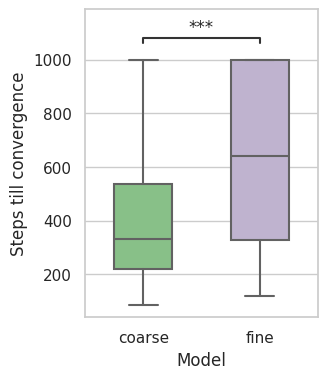

In [103]:
labels = ['coarse', 'fine']
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(3, 4))
    df_ = df
    coarse = df_[df_.model == 'coarse'].conv_steps.values
    fine = df_[df_.model == 'fine'].conv_steps.values
    df_ = pd.DataFrame(list(zip(coarse, fine)), columns=labels)
    ax = sns.boxplot(data=df_, palette=colors, width=0.5, order=['coarse', 'fine'])
    ax.set(ylabel='Steps till convergence',
           xlabel='Model')
    annotator = Annotator(ax, [labels], data=df_)
    annotator.configure(test='Mann-Whitney', text_format='star', verbose=1)
    annotator.apply_and_annotate()
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

coarse vs. fine: t-test paired samples, P_val:9.155e-05 t=-4.279e+00


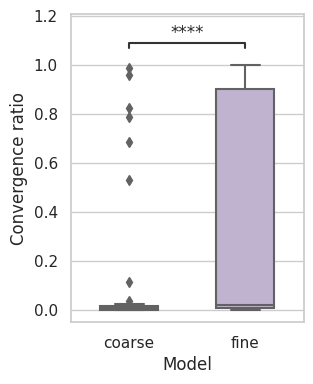

In [17]:
labels = ['coarse', 'fine']
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(3,4))
    df_ = df
    coarse = df_[df_.coarse].ratio.values
    fine = df_[df_.coarse == False].ratio.values
    df_ = pd.DataFrame(list(zip(coarse, fine)), columns=labels)
    ax = sns.boxplot(data=df_, palette=colors, width=0.5)
    ax.set(ylabel='Convergence ratio',
           xlabel='Model')
    annotator = Annotator(ax, [labels], data=df_)
    annotator.configure(test='t-test_paired', text_format='star', verbose=1)
    annotator.apply_and_annotate()
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

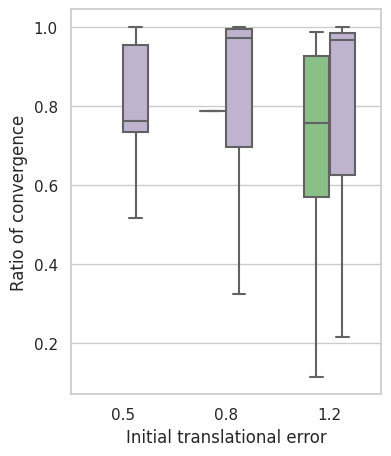

In [107]:
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(4, 5))
    df_ = df[df.converged == False]
    ax = sns.boxplot(data=df_, y='ratio', x='error', hue='model', hue_order=['coarse', 'fine'], palette=colors, width=0.5)
    ax.set(ylabel='Ratio of convergence')
    ax.set(xlabel='Initial translational error')
    ax.set_xticklabels([0.5, 0.8, 1.2])
    ax.get_legend().remove()

#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

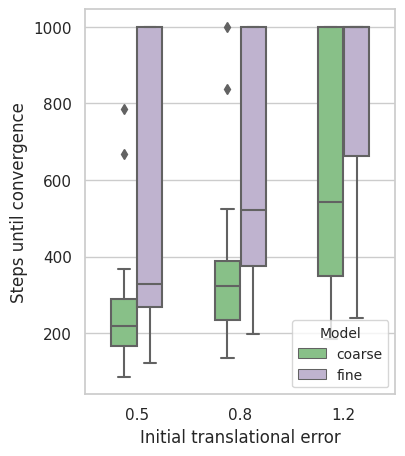

In [108]:
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(4, 5))
    df_ = df[df.converged == True]
    ax = sns.boxplot(data=df, y='conv_steps', x='error', hue='model', hue_order=['coarse', 'fine'], palette=colors, width=0.5)
    ax.set(ylabel='Steps until convergence')
    ax.set(xlabel='Initial translational error')
    ax.set_xticklabels([0.5, 0.8, 1.2])
    ax.get_legend().remove()

#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.legend(loc='lower right', title='Model')
plt.show()

# Depth

In [89]:
def load_depth_results():
    rows = []
    test_id = 194
    for subset in ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]:
        for use_depth in [False, True]:
            for error in [1, 2, 3]:
                for img_count in [1, 4, 8]:
                    file_name = os.path.join('results', f'{test_id:06d}-data.json')
                    with open(file_name, "r") as fp:
                        data = json.loads(fp.read())
                    converged, conv_steps, ratio = convergence_speed(data)
                    initial_error = round(np.linalg.norm(np.array(data['T_true']['t']) - np.array(data['T_init']['t'])), 1)
                    row = {'test_id': test_id,
                           'img_count': img_count,
                           'subset': subset,
                           'initial_error': initial_error,
                           'ratio': ratio,
                           'use_depth': use_depth,
                           'converged': converged,
                           'conv_steps': conv_steps}
                    rows.append(row)
                    test_id += 1
    return pd.DataFrame(rows)
df = load_depth_results()
initial_errors = sorted(df.initial_error.unique())
df.head(5)

,test_id,img_count,subset,initial_error,ratio,use_depth,converged,conv_steps
0,194,1,chair,0.5,0.002214,False,True,166
1,195,4,chair,0.5,0.002640,False,True,176
2,196,8,chair,0.5,0.003192,False,True,318
3,197,1,chair,0.9,0.003944,False,True,536
4,198,4,chair,0.9,0.001888,False,True,583


In [90]:
for use_depth in [False, True]:
    for initial_error in initial_errors:
        df_ = df[df.use_depth == use_depth]
        df_ = df_[df_.initial_error == initial_error]
        print(use_depth, initial_error, df_.converged.sum()/len(df_)*100)

False 0.5 95.83333333333334
False 0.9 95.83333333333334
False 1.2 70.83333333333334
True 0.5 100.0
True 0.9 100.0
True 1.2 91.66666666666666


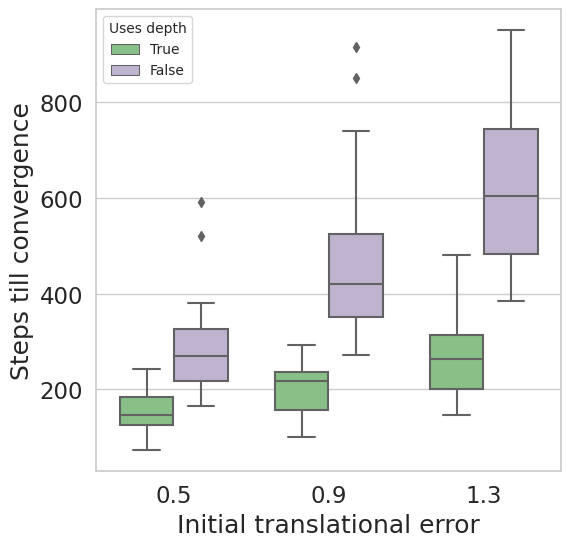

In [91]:
with sns.plotting_context('notebook', font_scale=1.5):
    plt.figure(figsize=(6, 6))
    df_ = df[df.converged]
    ax = sns.boxplot(data=df_, y='conv_steps', x='initial_error', hue='use_depth', hue_order=[True, False],  palette=colors, width=0.7)
    ax.set(ylabel='Steps till convergence',
           xlabel='Initial translational error')
    ax.set_xticklabels([0.5, 0.9, 1.3])
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.legend(title='Uses depth')
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

depth vs. no_depth: t-test paired samples, P_val:2.425e-14 t=-9.535e+00


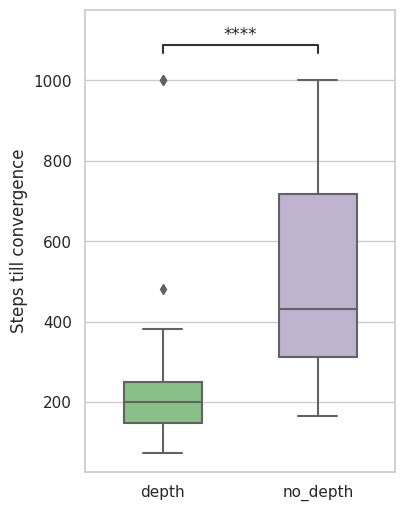

In [15]:
labels = ['depth', 'no_depth']
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(4,6))
    df_ = df#df[df.converged]
    depth = df_[df_.use_depth].conv_steps.values
    no_depth = df_[df_.use_depth == False].conv_steps.values
    df_ = pd.DataFrame(list(zip(depth, no_depth)), columns=labels)
    ax = sns.boxplot(data=df_, palette=colors, width=0.5)
    ax.set(ylabel='')
    annotator = Annotator(ax, [labels], data=df_)
    annotator.configure(test='t-test_paired', text_format='star', verbose=1)
    annotator.apply_and_annotate()
    ax.set(ylabel='Steps till convergence')
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

# Multi img

In [444]:
def load_multi_results():
    rows = []
    test_id = 678
    for subset in ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]:
        for img_count in [1, 4, 8]:
            file_name = os.path.join('results', f'{test_id:06d}-data.json')
            with open(file_name, "r") as fp:
                data = json.loads(fp.read())
            converged, conv_steps, ratio = convergence_speed(data, 0.05)
            row = {'test_id': test_id,
                   'img_count': img_count,
                   'subset': subset,
                   'ratio': ratio,
                   'converged': converged,
                   'conv_steps': conv_steps}
            rows.append(row)
            test_id += 1
    return pd.DataFrame(rows)
df = load_multi_results()
df.head(5)

,test_id,img_count,subset,ratio,converged,conv_steps
0,678,1,chair,0.599987,False,1000
1,679,4,chair,0.160575,False,1000
2,680,8,chair,0.030836,True,929
3,681,1,drums,0.529201,False,1000
4,682,4,drums,0.459096,False,1000


In [445]:
for img_count in sorted(df.img_count.unique()):
    df_ = df[df.img_count == img_count]
    print(img_count, df_.converged.sum()/len(df_)*100)

1 37.5
4 25.0
8 37.5


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 4: t-test paired samples, P_val:3.011e-01 t=1.955e+00
1 vs. 8: t-test paired samples, P_val:6.867e-01 t=-5.361e-01


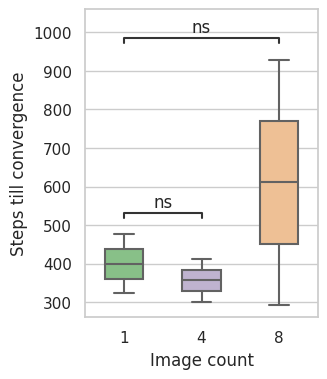

In [451]:
img_counts = sorted(df.img_count.unique())
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(3,4))
    df_ = df[df.converged==True]
    ratios = [df_[df_.img_count == img_count].conv_steps.values for img_count in img_counts]
    df_ = pd.DataFrame(list(zip(*ratios)), columns=img_counts)
    ax = sns.boxplot(data=df_, palette=colors, width=0.5)
    ax.set(ylabel='Steps till convergence', xlabel='Image count')
    annotator = Annotator(ax, [(img_counts[0], img_counts[1]),
                               (img_counts[0], img_counts[2])], data=df_)
    annotator.configure(test='t-test_paired', text_format='star', verbose=1)
    annotator.apply_and_annotate()
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:7.984e-01 U_stat=3.500e+01
1 vs. 8: Mann-Whitney-Wilcoxon test two-sided, P_val:5.737e-01 U_stat=3.800e+01


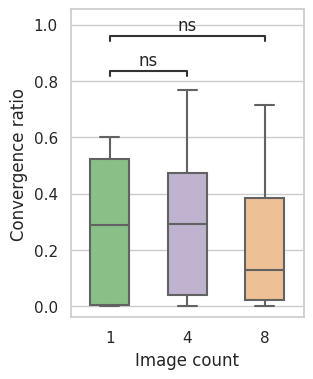

In [454]:
img_counts = sorted(df.img_count.unique())
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(3,4))
    df_ = df#df[df.converged==True]
    ratios = [df_[df_.img_count == img_count].ratio.values for img_count in img_counts]
    df_ = pd.DataFrame(list(zip(*ratios)), columns=img_counts)
    ax = sns.boxplot(data=df_, palette=colors, width=0.5)
    ax.set(ylabel='Convergence ratio', xlabel='Image count')
    annotator = Annotator(ax, [(img_counts[0], img_counts[1]),
                               (img_counts[0], img_counts[2])], data=df_)
    annotator.configure(test='Mann-Whitney', text_format='star', verbose=1)
    annotator.apply_and_annotate()
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

In [92]:
def load_step_results():
    rows = []
    test_id = 482
    for subset in ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]:
        for step in [1, 2, 4, 8, 16]:
            for error in [2, 4, 8]:
                file_name = os.path.join('results', f'{test_id:06d}-data.json')
                with open(file_name, "r") as fp:
                    data = json.loads(fp.read())
                converged, conv_steps, ratio = convergence_speed(data)
                initial_error = round(np.linalg.norm(np.array(data['T_true']['t']) - np.array(data['T_init']['t'])), 1)
                row = {'test_id': test_id,
                       'step': step,
                       'subset': subset,
                       'error': initial_error,
                       'ratio': ratio,
                       'converged': converged,
                       'conv_steps': conv_steps}
                rows.append(row)
                test_id += 1
    return pd.DataFrame(rows)
df = load_step_results()
df.head(5)

,test_id,step,subset,error,ratio,converged,conv_steps
0,482,1,chair,1.0,0.005606,True,370
1,483,1,chair,1.8,0.003519,True,644
2,484,1,chair,3.6,0.656302,False,1000
3,485,2,chair,1.0,0.003956,True,200
4,486,2,chair,1.8,0.002906,True,598


In [93]:
for step in sorted(df.step.unique()):
    df_ = df[df.step == step]
    print(step, df_.converged.sum()/len(df_)*100)

1 58.333333333333336
2 66.66666666666666
4 62.5
8 83.33333333333334
16 79.16666666666666


In [94]:
for step in sorted(df.step.unique()):
    for error in sorted(df.error.unique()):
        df_ = df[df.step == step]
        df_ = df_[df_.error == error]
        print(step, error, df_.converged.sum()/len(df_)*100)

1 1.0 87.5
1 1.8 75.0
1 3.6 12.5
2 1.0 87.5
2 1.8 75.0
2 3.6 37.5
4 1.0 87.5
4 1.8 75.0
4 3.6 25.0
8 1.0 100.0
8 1.8 100.0
8 3.6 50.0
16 1.0 100.0
16 1.8 100.0
16 3.6 37.5


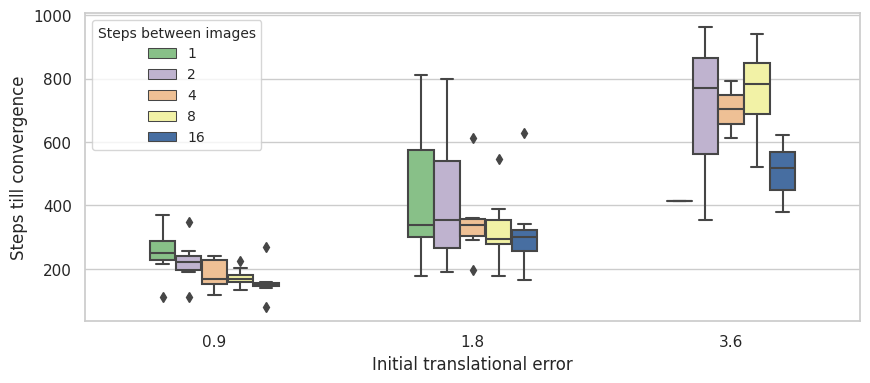

In [95]:
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(10, 4))
    df_ = df[df.converged]
    ax = sns.boxplot(data=df_, hue='step', y='conv_steps', x='error',  palette=colors, width=0.5)
    ax.set(ylabel='Steps till convergence',
           xlabel='Initial translational error')
    ax.set_xticklabels([0.9, 1.8, 3.6])
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.legend(title='Steps between images')
plt.show()

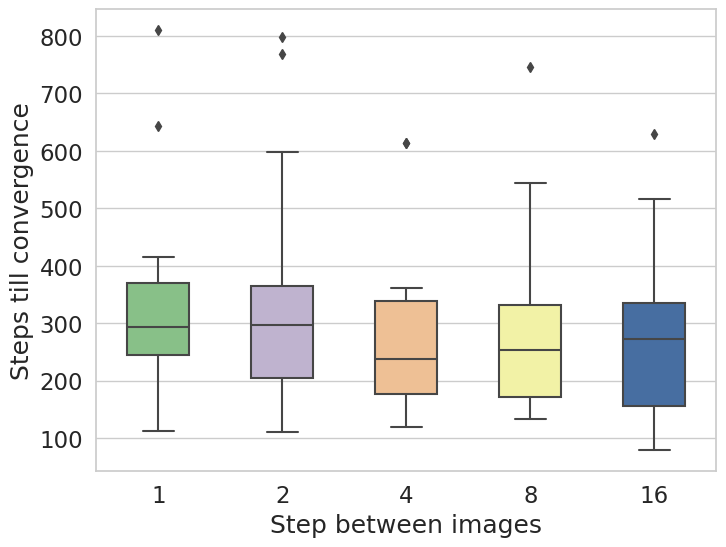

In [97]:
with sns.plotting_context('notebook', font_scale=1.5):
    plt.figure(figsize=(8, 6))
    df_ = df[df.converged]
    steps = sorted(df_.step.unique())
    conv_steps = [df_[df_.step == step].conv_steps.values for step in steps]
    df_ = pd.DataFrame(list(zip(*conv_steps)), columns=steps)
    ax = sns.boxplot(data=df_, palette=colors, width=0.5)
    ax.set(ylabel='Steps till convergence',
           xlabel='Step between images')
    plt.xlabel('Step between images')
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

# Convergence

In [250]:
def load_conv_results():
    rows = []
    test_id = 434
    for subset in ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]:
        for error in [4, 6, 8, 10, 12, 14]:
            file_name = os.path.join('results', f'{test_id:06d}-data.json')
            with open(file_name, "r") as fp:
                data = json.loads(fp.read())
            converged, conv_steps, ratio = convergence_speed(data)
            row = {'test_id': test_id,
                   'subset': subset,
                   'error': error,
                   'ratio': ratio,
                   'converged': converged,
                   'conv_steps': conv_steps}
            rows.append(row)
            test_id += 1
    return pd.DataFrame(rows)
df = load_conv_results()
df.head(5)

,test_id,subset,error,ratio,converged,conv_steps
0,434,chair,4,0.006640,True,393
1,435,chair,6,0.006668,True,592
2,436,chair,8,0.563037,False,1000
3,437,chair,10,0.804066,False,1000
4,438,chair,12,0.791432,False,1000


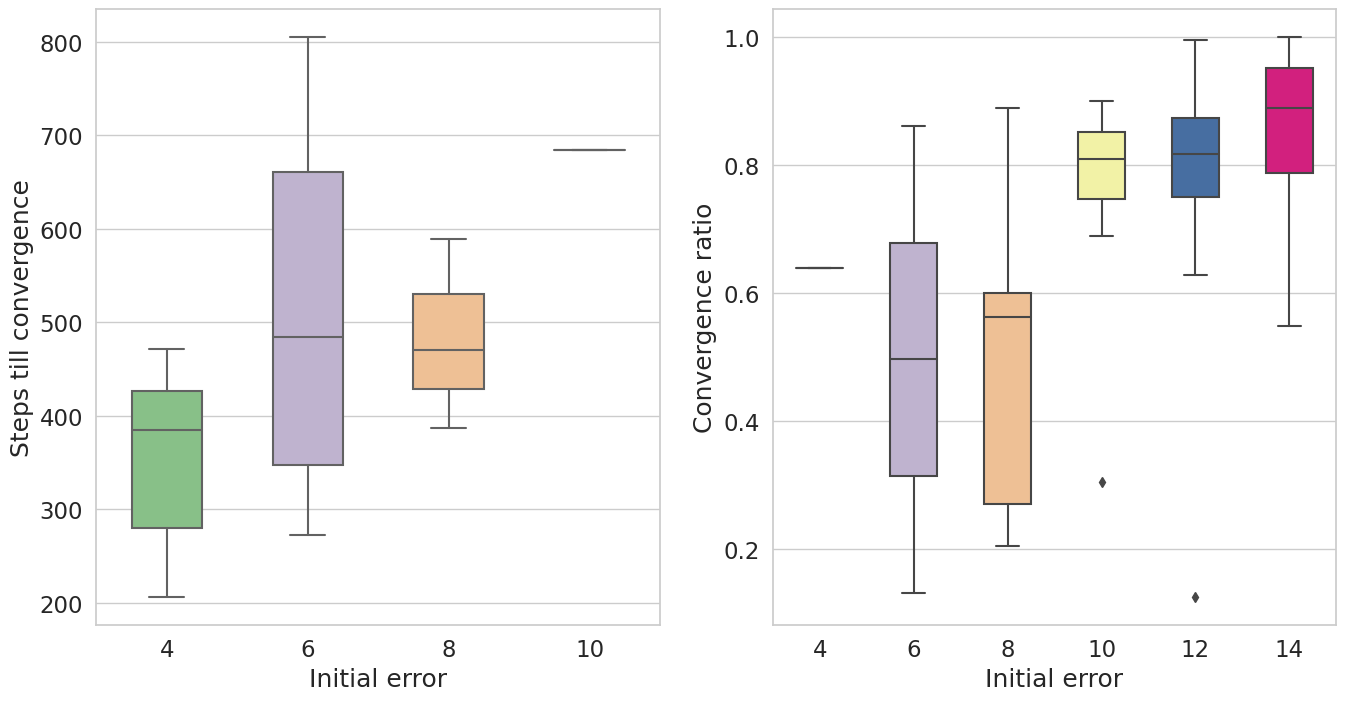

In [252]:
with sns.plotting_context('notebook', font_scale=1.5):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    ax = sns.boxplot(data=df[df.converged], y='conv_steps', x='error', palette=colors, width=0.5, ax=axs[0])
    ax.set(ylabel='Steps till convergence', xlabel='Initial error')
    ax = sns.boxplot(data=df[df.converged == False], y='ratio', x='error', palette=colors, width=0.5, ax=axs[1])
    ax.set(ylabel='Convergence ratio', xlabel='Initial error')
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

# BS

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. normal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.980e-07 U_stat=2.730e+02
normal vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:5.140e-09 U_stat=2.140e+02


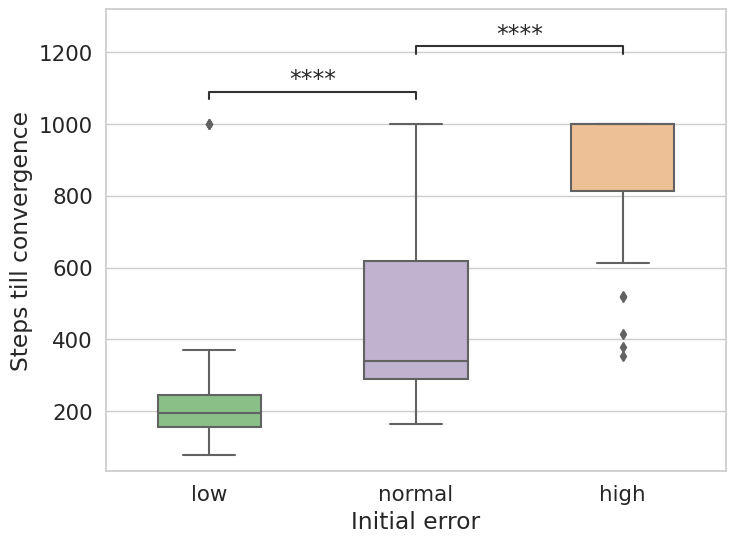

In [47]:
conv_steps = [df[df.error == error].conv_steps.values for error in sorted(df.error.unique())]
df_ = pd.DataFrame(list(zip(*conv_steps)), columns = ['low','normal', 'high'])
with sns.plotting_context('notebook', font_scale = 1.4):
  plt.figure(figsize=(8,6))
  ax = sns.boxplot(data=df_, palette=colors, width=0.5)
  ax.set(ylabel='Steps till convergence',
         xlabel='Initial error')
  pairs=[("low", "normal"), ("normal", "high")]
  annotator = Annotator(ax, pairs, data=df_)
  annotator.configure(test='Mann-Whitney', text_format='star', verbose=1)
  annotator.apply_and_annotate()
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

# IDNeRF vs INeRF

In [29]:
def load_idnerf_vs_nerf_results():
    rows = []
    test_id = 705
    for subset in ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]:
         for algorithm in ['BID-NeRF', 'INeRF']:
            for error in [1, 2, 4]:
                file_name = os.path.join('results', f'{test_id:06d}-data.json')
                with open(file_name, "r") as fp:
                    data = json.loads(fp.read())
                converged, conv_steps, ratio = convergence_speed(data)
                row = {'test_id': test_id,
                       'subset': subset,
                       'algorithm': algorithm,
                       'error': error,
                       'ratio': ratio,
                       'converged': converged,
                       'conv_steps': conv_steps}
                rows.append(row)
                test_id += 1
    return pd.DataFrame(rows)
df = load_idnerf_vs_nerf_results()
print(len(df))
df.head(5)

48


,test_id,subset,algorithm,error,ratio,converged,conv_steps
0,705,chair,BID-NeRF,1,0.017844,True,100
1,706,chair,BID-NeRF,2,0.007999,True,183
2,707,chair,BID-NeRF,4,0.006826,True,376
3,708,chair,INeRF,1,0.004720,True,486
4,709,chair,INeRF,2,0.013285,True,624


In [30]:
for algorithm in sorted(df.algorithm.unique()):
    for error in sorted(df.error.unique()):
        df_ = df[df.algorithm == algorithm]
        df_ = df_[df_.error == error]
        print(algorithm, error, df_.converged.sum()/len(df_)*100)
print('Overall')
print('BID-NeRF', df[df.algorithm == 'BID-NeRF'].converged.sum()/len(df[df.algorithm == 'BID-NeRF'])*100)
print('INeRF', df[df.algorithm == 'INeRF'].converged.sum()/len(df[df.algorithm == 'INeRF'])*100)

BID-NeRF 1 100.0
BID-NeRF 2 100.0
BID-NeRF 4 87.5
INeRF 1 50.0
INeRF 2 50.0
INeRF 4 0.0
Overall
BID-NeRF 95.83333333333334
INeRF 33.33333333333333


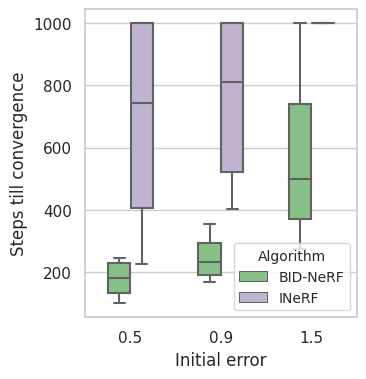

In [9]:
with sns.plotting_context('notebook', font_scale=1.):
    plt.figure(figsize=(3.5, 4))
    ax = sns.boxplot(data=df, y='conv_steps', x='error', hue='algorithm', palette=colors, width=0.5)
    ax.set(ylabel='Steps till convergence', xlabel='Initial error')
    ax.set_xticklabels([0.5, 0.9, 1.5])
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.legend(loc='lower right', title='Algorithm')
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BID-NeRF vs. INeRF: Mann-Whitney-Wilcoxon test two-sided, P_val:1.044e-06 U_stat=5.600e+01


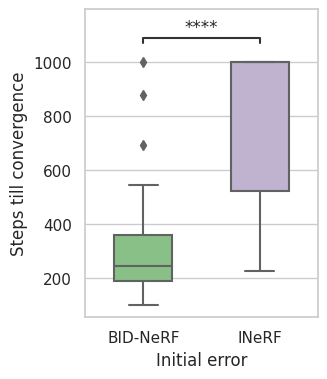

In [31]:
algorithms = sorted(df.algorithm.unique())
conv_steps = [df[df.algorithm == algorithm].conv_steps.values for algorithm in algorithms]
df_ = pd.DataFrame(list(zip(*conv_steps)), columns = algorithms)
with sns.plotting_context('notebook', font_scale = 1.):
  plt.figure(figsize=(3,4))
  ax = sns.boxplot(data=df_, palette=colors, width=0.5)
  ax.set(ylabel='Steps till convergence',
         xlabel='Initial error')
  annotator = Annotator(ax, [algorithms], data=df_)
  annotator.configure(test='Mann-Whitney', text_format='star', verbose=1)
  annotator.apply_and_annotate()
#plt.savefig("diagrams/plotVII.png",dpi=200)
plt.show()

# Plots

In [110]:
import jaxlie
import math

def degrees(data):
    r_true = jaxlie.SO3.exp(np.array(data['T_true']['R']))
    one = np.array([0., 0., 1.])
    degrees = []
    for t_pred_log in data['history']['log_T_pred']:
        r_pred = jaxlie.SE3.exp(np.array(t_pred_log)).rotation()
        rotated1 = r_true.apply(one)
        rotated2 = r_pred.apply(one)
        assert abs(np.linalg.norm(rotated2)-1.) < 1e-4
        degree = math.degrees(np.arccos(np.clip(np.dot(rotated1, rotated2), -1.0, 1.0)))
        degrees.append(degree)
    return degrees

In [111]:
rows = []
for i, test_id in enumerate(range(705, 705+6)):
    file_name = os.path.join('results', f'{test_id:06d}-data.json')
    algorithm = 'BID-NeRF' if i < 3 else 'INeRF'
    with open(file_name, "r") as fp:
        data = json.loads(fp.read())
    initial_error = round(np.linalg.norm(data['history']['t_error'][0]), 1)

    for step, (t_error, degree) in enumerate(zip(data['history']['t_error'],
                                                  degrees(data))):
        rows.append({'step': step,
                     't_error': t_error,
                     'algorithm': algorithm,
                     'r_error': degree,
                     'initial_error': initial_error,
                     'test_id': test_id,})
df = pd.DataFrame(rows)
initial_errors = sorted(df.initial_error.unique())
df.head(5)

,step,t_error,algorithm,r_error,initial_error,test_id
0,0,0.429738,BID-NeRF,5.367610,0.4,705
1,1,0.422411,BID-NeRF,5.260267,0.4,705
2,2,0.419867,BID-NeRF,4.791011,0.4,705
3,3,0.413531,BID-NeRF,4.446644,0.4,705
4,4,0.406626,BID-NeRF,4.185164,0.4,705


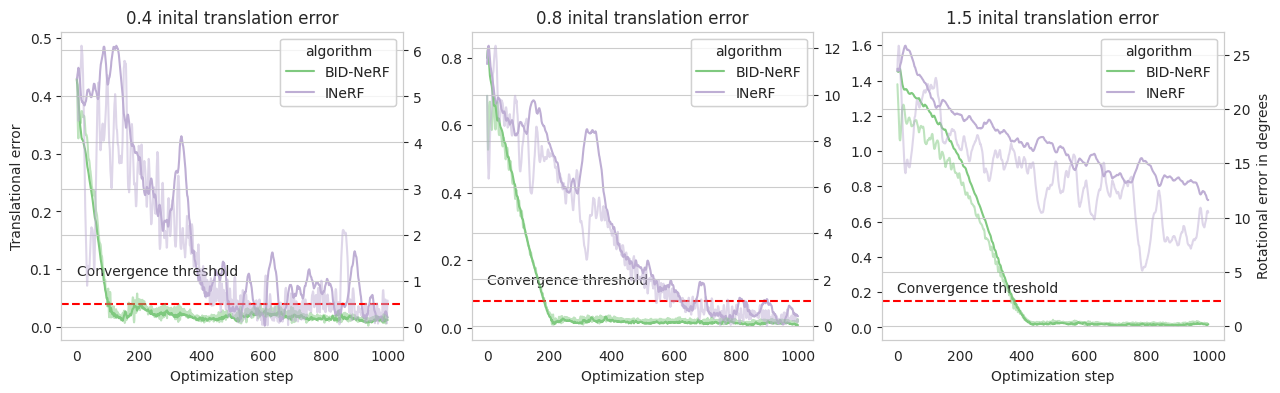

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, (ax, initial_error) in enumerate(zip(axs, initial_errors)):
    ax2 = ax.twinx()
    ax.grid(False)
    sns.lineplot(data=df[df.initial_error == initial_error], x='step', y='t_error', hue='algorithm', palette=colors, hue_order=['BID-NeRF', 'INeRF'], ax=ax, legend='brief', label="")
    sns.lineplot(data=df[df.initial_error == initial_error], x='step', y='r_error', hue='algorithm', palette=colors, hue_order=['BID-NeRF', 'INeRF'], ax=ax2, alpha=0.5)

    threshold = initial_error*0.1

    ax.axhline(y=threshold, color='r', linestyle='--')
    ax.text(0, threshold+0.05, 'Convergence threshold')
    ax.set_title(f'{initial_error:.1f} inital translation error')
    ax.set(xlabel='Optimization step')
    if i == 0:
        ax.set(ylabel='Translational error')
    else:
        ax.set(ylabel='')
    if i == 2:
        ax2.set(ylabel='Rotational error in degrees')
    else:
        ax2.set(ylabel='')

plt.show()

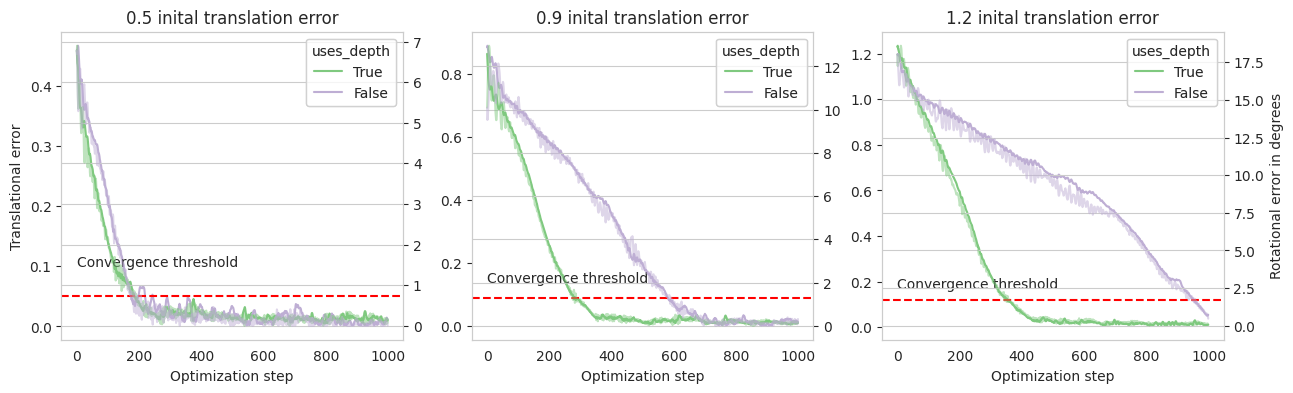

In [84]:
rows = []
for i, test_id in enumerate([204, 207, 210,
                             195, 198, 201]):
    file_name = os.path.join('results', f'{test_id:06d}-data.json')
    uses_depth = i < 3
    with open(file_name, "r") as fp:
        data = json.loads(fp.read())
    initial_error = round(np.linalg.norm(data['history']['t_error'][0]), 1)

    for step, (t_error, degree) in enumerate(zip(data['history']['t_error'],
                                                  degrees(data))):
        rows.append({'step': step,
                     't_error': t_error,
                     'uses_depth': uses_depth,
                     'r_error': degree,
                     'initial_error': initial_error,
                     'test_id': test_id,})
df = pd.DataFrame(rows)
initial_errors = sorted(df.initial_error.unique())
df.head(5)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, (ax, initial_error) in enumerate(zip(axs, initial_errors)):
    ax2 = ax.twinx()
    ax.grid(False)
    sns.lineplot(data=df[df.initial_error == initial_error], x='step', y='t_error', hue='uses_depth', palette=colors, hue_order=[True, False], ax=ax, legend='brief', label="")
    sns.lineplot(data=df[df.initial_error == initial_error], x='step', y='r_error', hue='uses_depth', palette=colors, hue_order=[True, False], ax=ax2, alpha=0.5)

    threshold = initial_error*0.1

    ax.axhline(y=threshold, color='r', linestyle='--')
    ax.text(0, threshold+0.05, 'Convergence threshold')
    ax.set_title(f'{initial_error:.1f} inital translation error')
    ax.set(xlabel='Optimization step')
    if i == 0:
        ax.set(ylabel='Translational error')
    else:
        ax.set(ylabel='')
    if i == 2:
        ax2.set(ylabel='Rotational error in degrees')
    else:
        ax2.set(ylabel='')

plt.show()

In [ ]:
rows = []
test_id = 654
file_name = os.path.join('results', f'{test_id:06d}-data.json')
uses_depth = i < 3
with open(file_name, "r") as fp:
    data = json.loads(fp.read())
for step, (t_error, R_error, loss) in enumerate(zip(data['history']['t_error'],
                                                    data['history']['loss'],
                                                    data['history']['R_error'])):
    rows.append({'step': step,
                 'value': t_error,
                 'error_type': 'translation',
                 'initial_error': round(data['configs']['perturbation_t'], 1),
                 'test_id': test_id,})
    rows.append({'step': step,
                 'value': R_error,
                 'error_type': 'rotation',
                 'initial_error': round(data['configs']['perturbation_t'], 1),
                 'test_id': test_id,})
    rows.append({'step': step,
                 'value': R_error,
                 'error_type': 'rotation',
                 'initial_error': round(data['configs']['perturbation_t'], 1),
                 'test_id': test_id,})
df = pd.DataFrame(rows)
df.head(5)

with sns.plotting_context('notebook', font_scale = 1.4, rc={'figure.figsize':(11.7,15.27)}):
    axs = sns.relplot(data=df, x='step', y='value', hue='uses_depth', col='initial_error', style='error_type', palette=colors, kind='line', height = 5)

for i, initial_error in enumerate(sorted(df.initial_error.unique())):
    initial_error = df[(df.error_type == 'translation') & (df.step == 0) & (df.initial_error == initial_error)].value.values[0]
    threshold = initial_error*0.1
    ax = axs.axes[0,i]
    ax.axhline(y=threshold, color='r', linestyle='--')
    ax.text(0, threshold+0.05, 'Convergence threshold')
    ax.set_title(f'{initial_error:.1f} inital translation error')
    ax.set(xlabel='Optimization step')
    if i == 0:
        ax.set(ylabel='Error in tangent space')
plt.show()